# Data Scientist Challenge

## Goal
As a TRI-AD data scientist you will need to have strong analytical skills as well as
experience building software and strong communication skills. This technical
challenge will cover all three of these components using a sample data set.
You will be provided with a data set about students. The data set includes
information about the students’ age, nationality, gender, as well as information
about their studying habits. There is also a binary column expressing whether or not
the students passed an important test.
## Tasks
- Describe the demographic details of people most likely to pass the test
- Describe the efficacy of the two interventions - the test prep course and the
Dojo class
- Identify any other interesting trends from the data set and offer some analysis
as to their importance or cause.

## Part 1: Importing the data from SQL & data cleaning

In [1]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Read database string from .env file
load_dotenv()

DB_STRING = os.getenv('DB_STRING')

db = create_engine(DB_STRING)

In [3]:

# Define query to download data
query_string = ''' 
set SCHEMA 'takemehome';SELECT * FROM triad;
'''

# Import with pandas
triad = pd.read_sql(query_string, db)
triad.head()

,sex,lang,country,age,hours_studied,dojo_class,test_prep,pass,notes
0,Male,Japanese,Japan,20,10.578594,True,False,True,None
1,Male,Japanese,Japan,22,7.814520,False,False,True,None
2,Male,Japanese,Japan,27,4.213682,False,False,True,None
3,Male,Japanese,Japan,24,NaN,False,False,True,None
4,Female,Japanese,Japan,21,3.248907,False,False,False,None


## Take a Look at the Data

In [4]:
triad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sex            5000 non-null   object 
 1   lang           5000 non-null   object 
 2   country        5000 non-null   object 
 3   age            5000 non-null   int64  
 4   hours_studied  3018 non-null   float64
 5   dojo_class     5000 non-null   bool   
 6   test_prep      5000 non-null   bool   
 7   pass           5000 non-null   bool   
 8   notes          772 non-null    object 
dtypes: bool(3), float64(1), int64(1), object(4)
memory usage: 249.2+ KB


In [5]:
triad.shape

(5000, 9)

## Data cleaning

After reviewing the data, I noticed there are no unique identifiers like student ID or name columns. This makes it hard to spot duplicate entries. So, I'll move on to dealing with missing data.

In [6]:
# Missing Data
triad.isna().sum().sort_values(ascending=False)

notes            4228
hours_studied    1982
sex                 0
lang                0
country             0
age                 0
dojo_class          0
test_prep           0
pass                0
dtype: int64

In [7]:
# to find the percentage of missing data in every column
missing_data_counts = triad.isna().sum().sort_values(ascending=False)
missing_data_percentage = (missing_data_counts / len(triad)) * 100
missing_data_percentage

notes            84.56
hours_studied    39.64
sex               0.00
lang              0.00
country           0.00
age               0.00
dojo_class        0.00
test_prep         0.00
pass              0.00
dtype: float64

### It appears that we only have two columns with missing data. Let's identify which columns those are.

In [8]:
# finding out what notes column contains
# filtered_notes = triad.loc[triad['notes'].notna(), 'notes']
# filtered_notes

filtered_triad = triad.loc[(triad['notes'].notna()) & (triad['notes'] != "None")]
filtered_triad

,sex,lang,country,age,hours_studied,dojo_class,test_prep,pass,notes
17,Male,Japanese,Japan,20,2.832802,False,False,False,CON
23,Male,Japanese,Japan,21,10.203002,True,False,False,"@{[system ""touch /tmp/blns.fail""]}"
46,Male,English,Australia,18,2.970848,False,False,True,`⁄€‹›ﬁﬂ‡°·‚—±
47,Female,French,France,21,NaN,False,False,True,᚛ᚄᚓᚐᚋᚒᚄ ᚑᚄᚂᚑᚏᚅ᚜
56,Female,Japanese,Japan,20,10.231923,False,False,False,Œ„´‰ˇÁ¨ˆØ∏”’
...,...,...,...,...,...,...,...,...,...
4980,Female,Japanese,Japan,22,8.569431,False,True,True,false
4981,Male,Japanese,Japan,20,2.883206,True,True,False,"<script\x0Ctype=""text/javascript"">javascript:a..."
4989,Male,Japanese,Japan,30,NaN,False,False,False,"ABC<div style=""x:\xE2\x80\x83expression(javasc..."
4993,Male,Japanese,Japan,18,5.223704,False,False,False,‫test‫


In [9]:
# finding out what hours_studied column is
n = triad.groupby('pass') ['hours_studied'].describe().T
n

pass,False,True
count,1600.000000,1418.000000
mean,4.517177,5.468335
std,2.903509,3.442488
min,0.139203,0.322662
25%,2.295112,2.946803
50%,3.936714,4.642625
75%,6.093244,7.347131
max,17.967449,24.259314


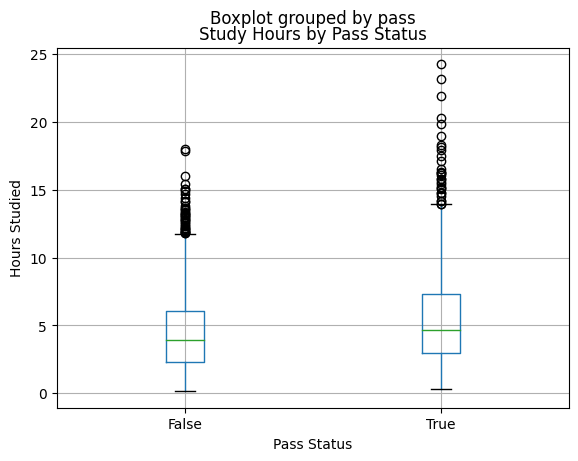

In [10]:
# Box plot
triad.boxplot(column='hours_studied', by='pass')
plt.title('Study Hours by Pass Status')
plt.ylabel('Hours Studied')
plt.xlabel('Pass Status')
plt.show()

/var/folders/vq/ylqs4w8n63n87c4lgq44_nj40000gn/T/ipykernel_4994/2415161621.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


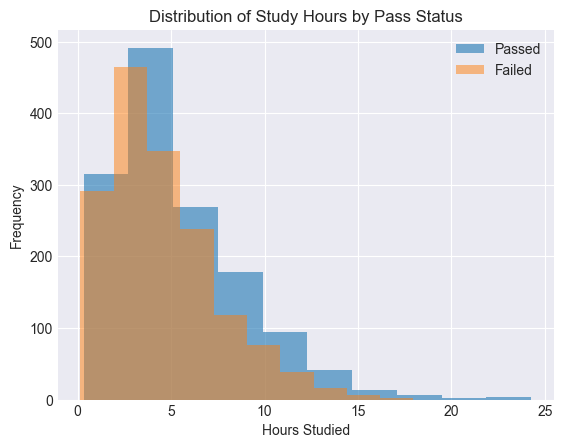

In [11]:
plt.style.use('seaborn-darkgrid')
passed = triad[triad['pass'] == 1]['hours_studied']
failed = triad[triad['pass'] == 0]['hours_studied']
plt.hist(passed, alpha=0.6, label='Passed')
plt.hist(failed, alpha=0.5, label='Failed')
plt.title('Distribution of Study Hours by Pass Status')
plt.xlabel('Hours Studied')
plt.ylabel('Frequency')
plt.legend()
plt.show()


---------------------------------------------------
As a result:

- The 'notes' column has over 80% of its data missing, and the available data is not comprehensible. Therefore, this column does not provide any meaningful information.
- The 'hours_studied' column has almost 40% missing data. There's a slight disparity in the average hours of study between students who passed and those who didn't. On average, students who passed studied for 5.47 hours, while those who didn't pass studied for 4.5 hours. However, this difference is relatively small and may not offer clear insights, especially considering the presence of significant outliers. I'll postpone deciding whether to impute the missing data in this column until later stages of analysis.

---------------------------------------------------
## EDA
I'll start by taking a general look at the data.

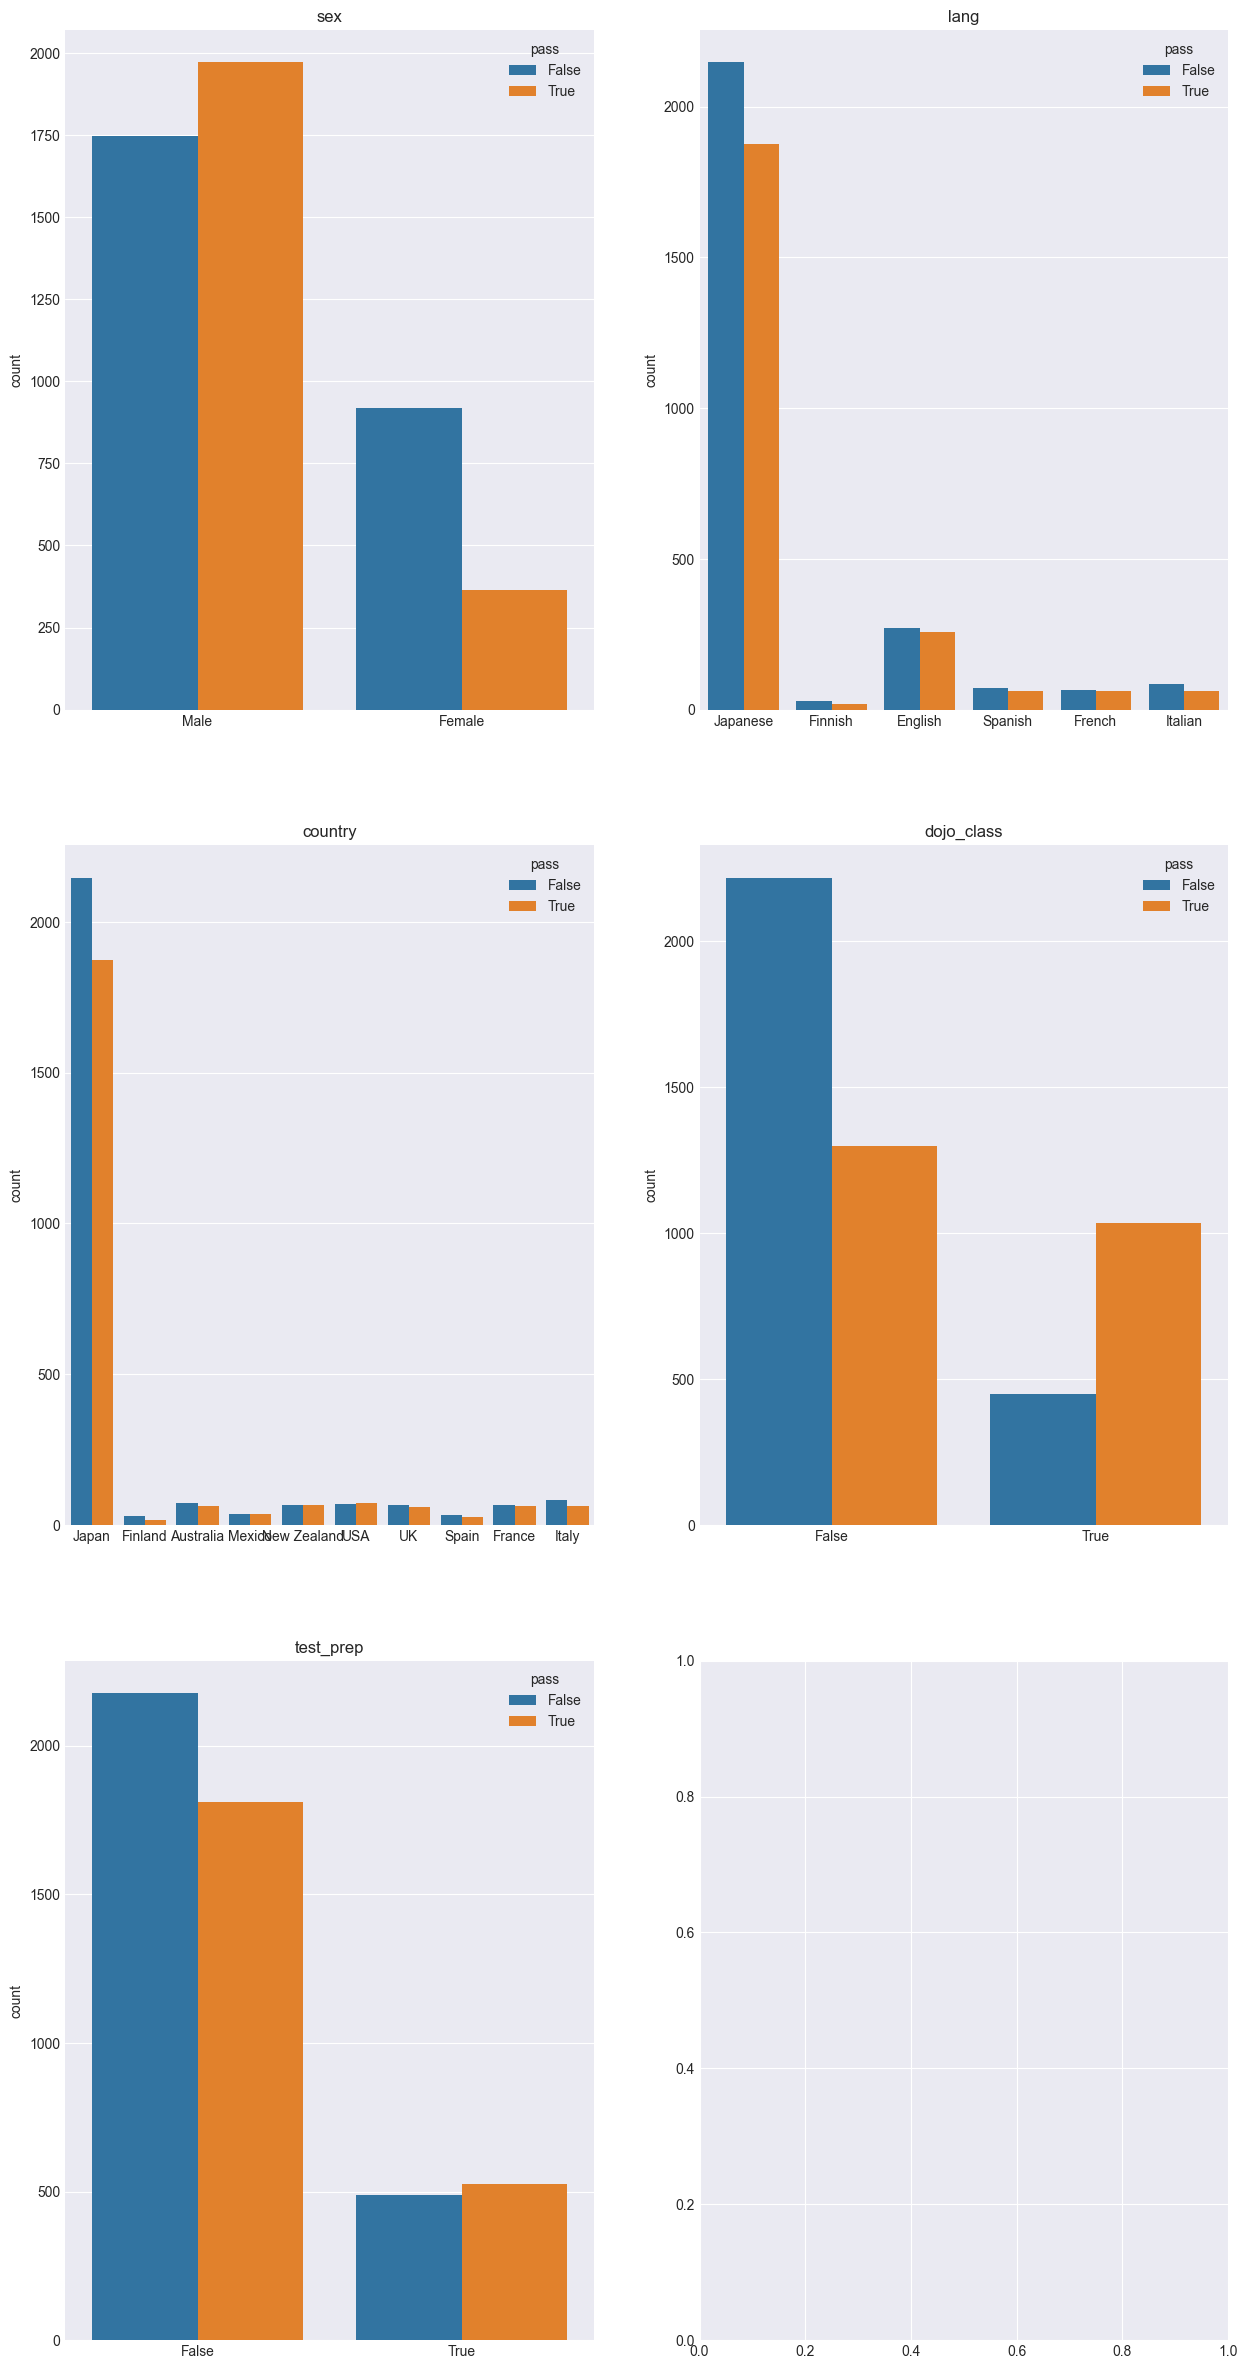

In [12]:
selected_columns = ['sex', 'lang', 'country', 'dojo_class', 'test_prep']
fig,ax = plt.subplots(3,2, figsize=(15,30))
count = 0
for item in selected_columns:
    sns.countplot(data=triad, x=item, hue="pass", ax=ax[int(count/2)][count%2]).set(title=item, xlabel='')
    count += 1

Text(0.5, 1.02, 'Pairplot of Categorical Variables')

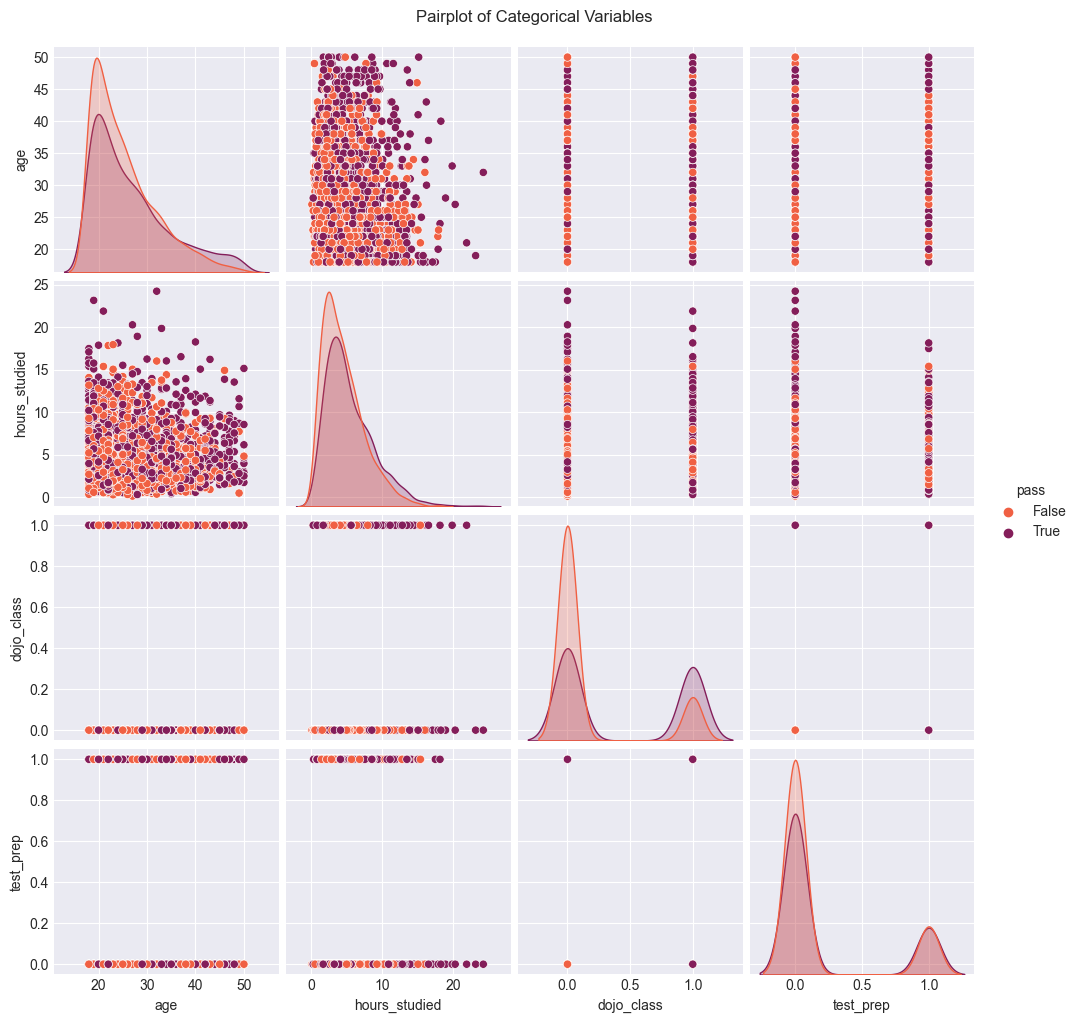

In [13]:
# Utilizing a Pairplot to gain further insights into the dataset.
sns.pairplot(triad, hue='pass', palette='rocket_r')
plt.suptitle('Pairplot of Categorical Variables', y=1.02)

Most male students passed the test, whereas most females did not.

---------------------------------------------------
### Now, I'll analyze each column individually to assess its impact on the target column (pass).

### Language Column

In [14]:
# Language column: 
lang1 = pd.crosstab(triad['pass'], triad['lang'])
lang1

lang,English,Finnish,French,Italian,Japanese,Spanish
pass,,,,,,
False,271,28,65,84,2147,70
True,257,17,63,61,1875,62


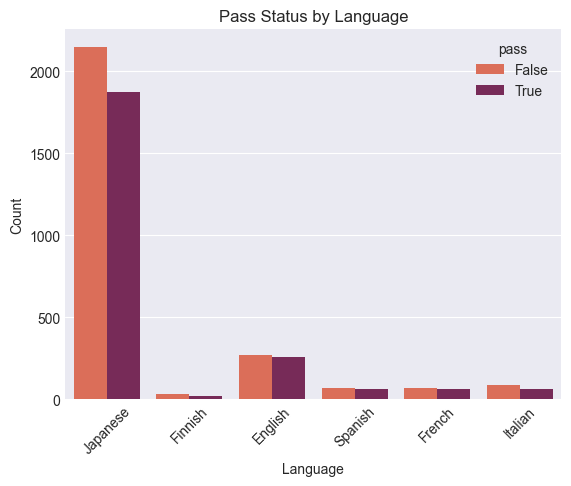

In [15]:
#plotting the result
sns.countplot(x=triad['lang'], hue=triad['pass'], palette='rocket_r')
plt.title('Pass Status by Language')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [16]:
lang2 = pd.crosstab(index=triad['pass'], columns=[triad['lang'], triad['sex']])
lang2

lang  English      Finnish      French      Italian      Japanese        \
sex    Female Male  Female Male Female Male  Female Male   Female  Male   
pass                                                                      
False     110  161      15   13     27   38      24   60      716  1431   
True       33  224       0   17      9   54       3   58      312  1563   

lang  Spanish       
sex    Female Male  
pass                
False      26   44  
True        6   56

In [17]:
lang3 = pd.crosstab(triad['dojo_class'], triad['lang'], margins=True)
lang3

lang,English,Finnish,French,Italian,Japanese,Spanish,All
dojo_class,,,,,,,
False,376,30,84,97,2847,84,3518
True,152,15,44,48,1175,48,1482
All,528,45,128,145,4022,132,5000


---------------------------------------------------
### Sex Column

In [18]:
# sex column
sex = pd.crosstab(triad['pass'], triad['sex'], margins=True)
sex

sex,Female,Male,All
pass,,,
False,918,1747,2665
True,363,1972,2335
All,1281,3719,5000


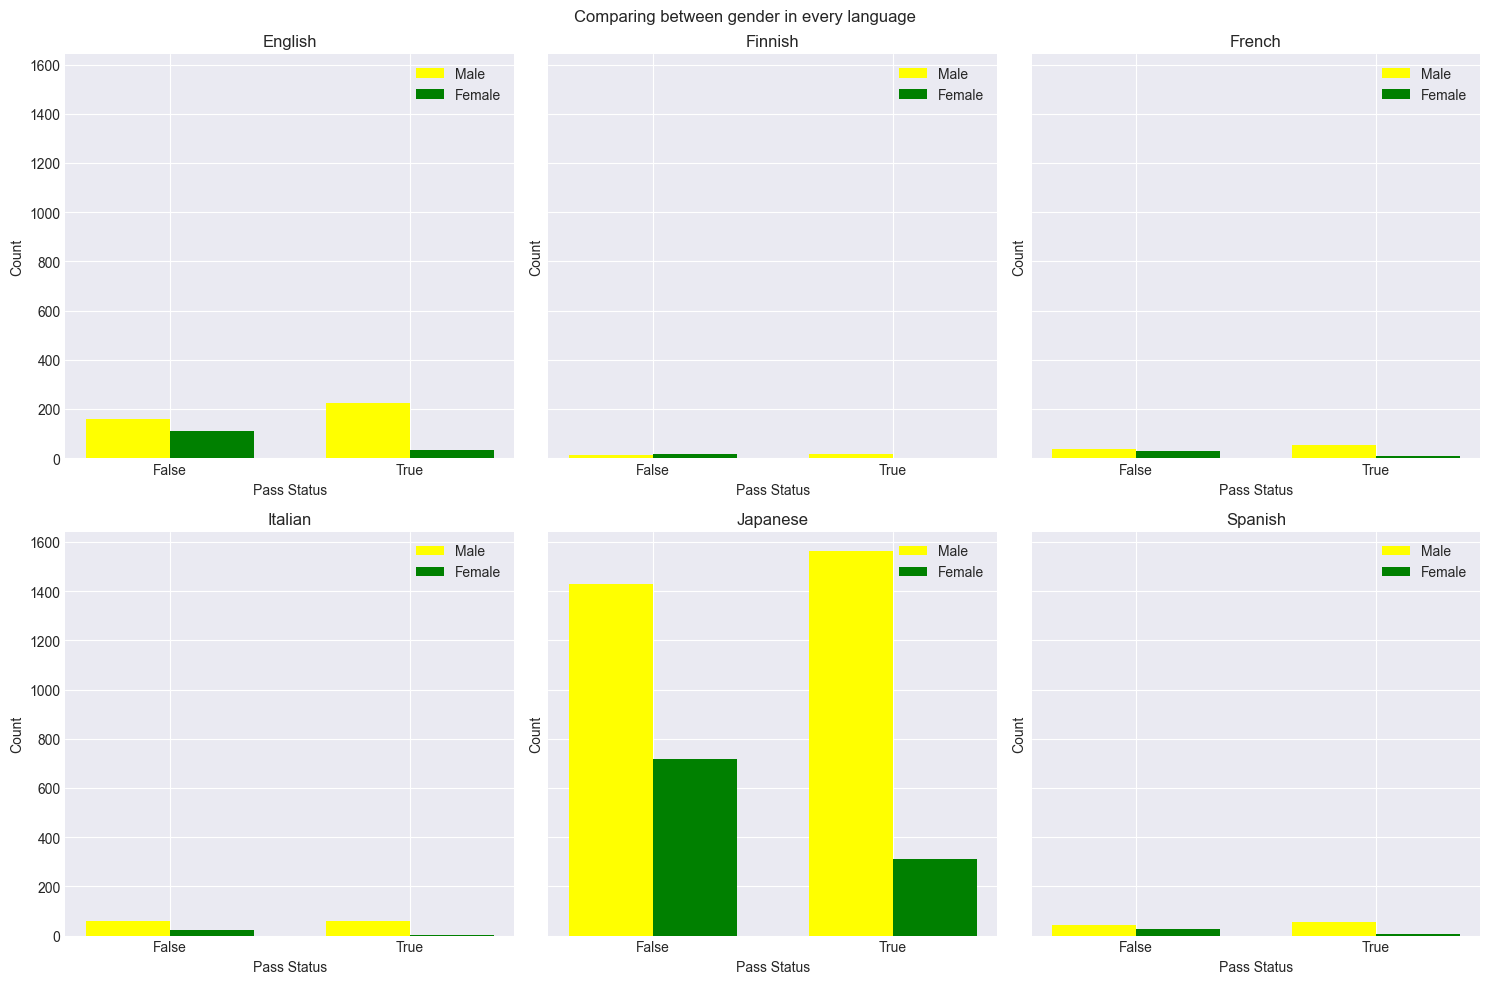

In [ ]:
# Comparing between gender in every language

languages = ['English', 'Finnish', 'French', 'Italian', 'Japanese', 'Spanish']

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
plt.suptitle('Comparing between gender in every language')

axes = axes.flatten()

# Plot each language separately
for i, lang in enumerate(languages):
    lang_data = lang2[lang]
    bar_width = 0.35 
    index = np.arange(len(lang_data))
    
    # Plot bars for male counts
    axes[i].bar(index - bar_width/2, lang_data['Male'], bar_width, color='yellow', label='Male')
    
    # Plot bars for female counts
    axes[i].bar(index + bar_width/2, lang_data['Female'], bar_width, color='green', label='Female')
    
    axes[i].set_title(lang)
    axes[i].set_xlabel('Pass Status')
    axes[i].set_ylabel('Count')
    axes[i].set_xticks(index)
    axes[i].set_xticklabels(lang_data.index)
    axes[i].legend()

plt.tight_layout()

plt.show()


---------------------------------------------------
### Country column


In [20]:
# Country column
triad.country.value_counts()

country
Japan          4022
Italy           145
USA             140
Australia       134
New Zealand     131
France          128
UK              123
Mexico           73
Spain            59
Finland          45
Name: count, dtype: int64

In [21]:
# Count the total number of individuals for each country
triad.groupby('country')['lang'].value_counts()

country      lang    
Australia    English      134
Finland      Finnish       45
France       French       128
Italy        Italian      145
Japan        Japanese    4022
Mexico       Spanish       73
New Zealand  English      131
Spain        Spanish       59
UK           English      123
USA          English      140
Name: count, dtype: int64

In [22]:
# Count the total number of individuals for each country
language_counts = triad.groupby(['country', 'lang']).size()
language_counts

country      lang    
Australia    English      134
Finland      Finnish       45
France       French       128
Italy        Italian      145
Japan        Japanese    4022
Mexico       Spanish       73
New Zealand  English      131
Spain        Spanish       59
UK           English      123
USA          English      140
dtype: int64

In [23]:
total_counts = triad.groupby('country').size()
total_counts

country
Australia       134
Finland          45
France          128
Italy           145
Japan          4022
Mexico           73
New Zealand     131
Spain            59
UK              123
USA             140
dtype: int64

In [24]:
# Count the total number of individuals for each country
total_counts = triad.groupby('country').size()

# Count the number of times each language appears for each country
language_counts = triad.groupby(['country', 'lang']).size()

# Calculate the percentage of individuals using their own language in each country
percentage_own_language = language_counts / total_counts * 100

percentage_own_language


country      lang    
Australia    English     100.0
Finland      Finnish     100.0
France       French      100.0
Italy        Italian     100.0
Japan        Japanese    100.0
Mexico       Spanish     100.0
New Zealand  English     100.0
Spain        Spanish     100.0
UK           English     100.0
USA          English     100.0
dtype: float64

---------------------------------------------------

In [25]:
# Age column
triad.age.describe()

count    5000.000000
mean       25.873400
std         7.349978
min        18.000000
25%        20.000000
50%        24.000000
75%        30.000000
max        50.000000
Name: age, dtype: float64

In [ ]:
# calculating rate of success depending on the gender
triad.groupby('sex')['pass'].apply(lambda x : (x==True).mean())

sex
Female    0.283372
Male      0.530250
Name: pass, dtype: float64

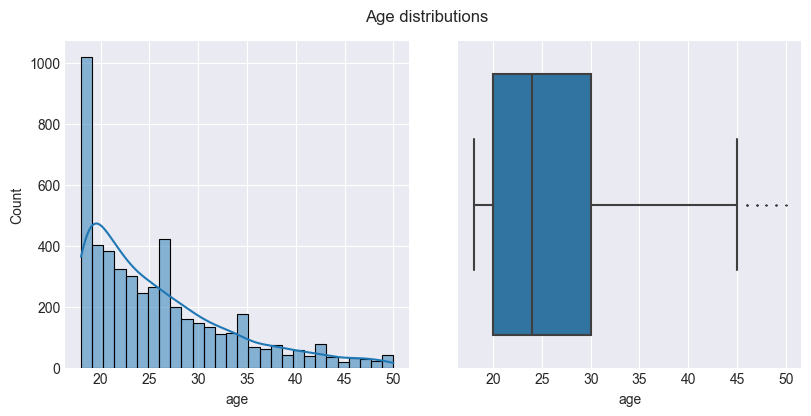

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.suptitle('Age distributions')

sns.histplot(data=triad, x="age", kde=True, ax=axes[0])

sns.boxplot(data=triad, x="age", fliersize=0.2, ax=axes[1])
plt.show()

In [27]:
triad.age.describe().T

count    5000.000000
mean       25.873400
std         7.349978
min        18.000000
25%        20.000000
50%        24.000000
75%        30.000000
max        50.000000
Name: age, dtype: float64

In [28]:
# The count of the student who pass (Outliers)
age1 = triad.query('age > 45')
age1.groupby('pass')['age'].count()

pass
False    29
True     94
Name: age, dtype: int64

In [29]:
age2 = triad.query('age <= 30')
age2.groupby('pass')['age'].count()

pass
False    2137
True     1737
Name: age, dtype: int64

---------------------------------------------------

In [30]:
# Test preperation column
triad['test_prep'].value_counts()

test_prep
False    3986
True     1014
Name: count, dtype: int64

In [31]:
prep = pd.crosstab(triad['pass'], triad['test_prep'], margins=True)
prep

test_prep,False,True,All
pass,,,
False,2177,488,2665
True,1809,526,2335
All,3986,1014,5000


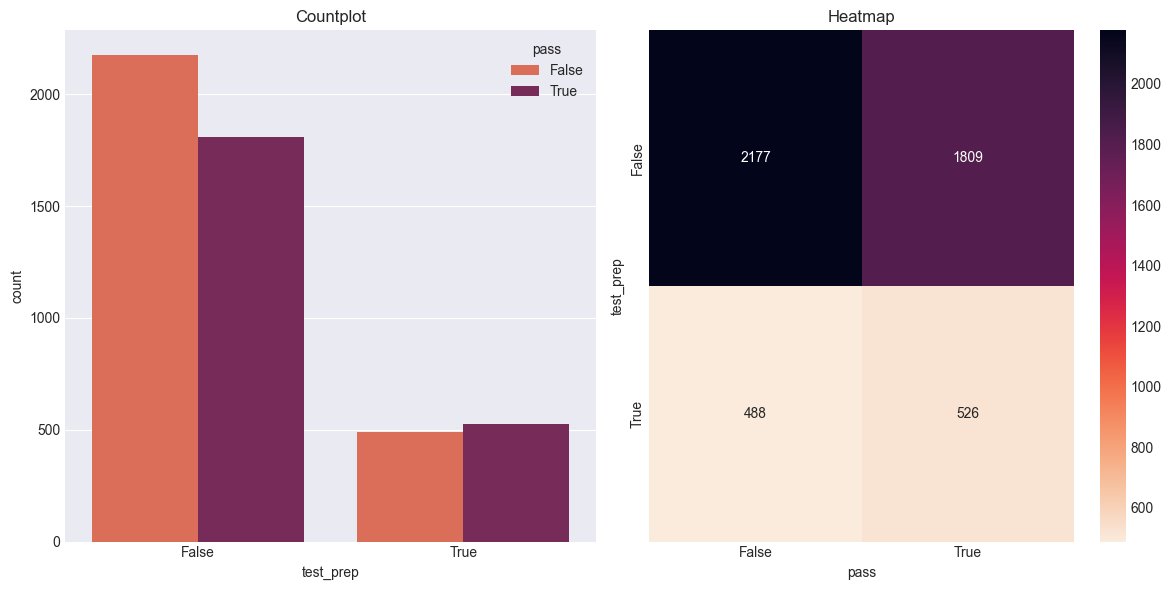

In [40]:

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot countplot on the first subplot
sns.countplot(x=triad['test_prep'], hue=triad['pass'], palette='rocket_r', ax=axes[0])
axes[0].set_title('Countplot')

# Create a contingency table
contingency_table = pd.crosstab(triad['test_prep'], triad['pass'])

# Plot heatmap on the second subplot
sns.heatmap(contingency_table, annot=True, cmap='rocket_r', fmt='d', ax=axes[1])
axes[1].set_title('Heatmap')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


---------------------------------------------------
trying to find a way to fill the missing data in hours studied column

In [33]:
triad.country.unique()

array(['Japan', 'Finland', 'Australia', 'Mexico', 'New Zealand', 'USA',
       'UK', 'Spain', 'France', 'Italy'], dtype=object)

In [34]:
print('Average study hours')
print('======'*10)
for i in triad.country.unique():
    print(f'Average study hours in {i}', triad[triad['country'] == i]['hours_studied'].mean())
    print('-----' *10)



Average study hours
Average study hours in Japan 5.001421202872876
--------------------------------------------------
Average study hours in Finland 5.047433574450273
--------------------------------------------------
Average study hours in Australia 4.4404081299185485
--------------------------------------------------
Average study hours in Mexico 4.824180069681567
--------------------------------------------------
Average study hours in New Zealand 4.894623829557743
--------------------------------------------------
Average study hours in USA 4.576522402318575
--------------------------------------------------
Average study hours in UK 4.6125696339898195
--------------------------------------------------
Average study hours in Spain 5.450664431265181
--------------------------------------------------
Average study hours in France 4.581623805621056
--------------------------------------------------
Average study hours in Italy 5.273289177506977
----------------------------------------

---------------------------------------------------
## Summary:

- All students took the test in their native language (100%).
- The majority of students were from Japan.
- Most students are male, a trend consistent across all countries.
- The majority of students fall between the ages of 18 and 30.
- More male students passed the test compared to female students.
- The average hours of study are similar between male and female students.
- Attending a dojo class appears to have a positive impact; approximately 60% of students who attended passed the test.
- Students over the age of 45 (considered outliers) had a higher likelihood of passing the test compared to younger students.
- Test preparation seems to have a slight positive effect. However, when comparing the total number of students who passed and failed with those who undertook test preparation, the difference is negligible.


---------------------------------------------------
## Saving the Data that I used

In [35]:
# Path = '/Users/mahmoudjaber/Neuefische/ds-take-me-home/data/Triad_data.csv'
# triad.to_csv(Path, index=False)